In [1]:
import tensorflow as tf
import numpy as np
from netCDF4 import Dataset
import time
import math

In [2]:
#Parameter List
parameter_list = {}

parameter_list['netCDf_loc'] = "./lorenz96_multi/DATA_sample/X40F18/all_10/nocorr_I20/assim.nc"
parameter_list['xlocal'] = 3
parameter_list['locality'] = 19
parameter_list['time_splits'] = 30
parameter_list['batch_size'] = 250
parameter_list['val_size'] = 2
parameter_list['LSTM_output'] = 5
parameter_list['net_output'] = 1
parameter_list['learning_rate'] = 1e-3
parameter_list['log_dir'] = './log'
parameter_list['checkpoint_dir'] = './checkpoint'
parameter_list['max_checkpoint_keep'] = 4
parameter_list['epochs'] = 5
parameter_list['log_freq'] = 5
parameter_list['early_stop_patience'] = 5
parameter_list['num_epochs_checkpoint'] = 2
parameter_list['summery_freq'] = 1

In [3]:
#Getting the NetCDF files
root_grp = Dataset(parameter_list['netCDf_loc'], "r", format="NETCDF4")

#Extrating the datasets
analysis_init = root_grp["vam"]
forecast_init = root_grp["vfm"]

In [4]:
#Creation of datasets for training and validation

#For creating locality for individual state variable
def locality_creator(init_dataset):
    
    output_dataset = np.zeros((init_dataset.shape[0], init_dataset.shape[1], parameter_list['locality']))
    radius = int(parameter_list['locality'] / 2)
    
    locality = np.linspace(-radius, radius, parameter_list['locality'])
    locality = np.true_divide(locality, parameter_list['xlocal'])
    locality = np.power(locality, 2)
    locality = np.exp((-1/2) * locality)
    
    for i in range(init_dataset.shape[1]):
        start = i - radius
        stop = i + radius
        index = np.linspace(start,stop,parameter_list['locality'], dtype='int')
        if stop >= init_dataset.shape[1]:
            stop2 = (stop + 1)%init_dataset.shape[1]
            index[:-stop2] = np.linspace(start,analysis_init.shape[1]-1,analysis_init.shape[1]-start, dtype='int')
            index[-stop2:] = np.arange(0,stop2,1,dtype='int')
        output_dataset[:,i,:] = init_dataset[:,index]

    return np.multiply(np.transpose(output_dataset,(1,0,2)), locality).astype('float32') 

#For creating the truth label
def truth_label_creator(init_dataset):
    output_dataset = init_dataset[:]
    output_dataset = np.expand_dims(output_dataset, axis=0)
    return np.transpose(output_dataset.astype('float32'))

analysis_dataset = truth_label_creator(analysis_init)
forecast_dataset = locality_creator(forecast_init)

In [5]:
print(analysis_dataset.shape)
print(forecast_dataset.shape)

(40, 7200, 1)
(40, 7200, 19)


In [6]:
#Creating time data splits
def split_sequences(sequences, n_steps):
    X = list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i*n_steps + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x = sequences[i*n_steps:end_ix, :]
        X.append(seq_x)
    return np.array(X)

In [7]:
#For serializing the tensor to a string for TFRecord
def _serialize_tensor(value):
    return tf.io.serialize_tensor(value)

In [8]:
#For writing data to the TFRecord file
def write_TFRecord(filename, dataset):
    with tf.io.TFRecordWriter(filename) as writer:
        for i in range(dataset.shape[0]):
            dataset_splits = split_sequences(dataset[i],parameter_list['time_splits'])
            for j in range(dataset_splits.shape[0]):
                data = dataset_splits[j]
                serial_string = _serialize_tensor(data)
                writer.write(serial_string.numpy())
    writer.close()

In [9]:
#For reading the TFRecord File
def read_TFRecord(filename):
    return tf.data.TFRecordDataset(filename)

#For parsing the value from string to float32
def _parse_tensor(value):
    return tf.io.parse_tensor(value, out_type=tf.float32)

In [10]:
write_TFRecord('analysis.tfrecord', analysis_dataset)
write_TFRecord('forecast.tfrecord', forecast_dataset)

In [11]:
#Reading the TFRecord files
anal_file = read_TFRecord('analysis.tfrecord')
fore_file = read_TFRecord('forecast.tfrecord')

#Parsing the dataset
anal_file = anal_file.map(_parse_tensor)
fore_file = fore_file.map(_parse_tensor)

In [12]:
#Zipping the files
dataset = tf.data.Dataset.zip((fore_file, anal_file))

#Shuffling the dataset
dataset = dataset.shuffle(100000)
dataset = dataset.batch(batch_size=parameter_list['batch_size'])

In [13]:
#For creating Train and Validation datasets

def train_val_creator(dataset, val_size):
    val_dataset = dataset.take(val_size)
    train_dataset = dataset.skip(val_size)
    return train_dataset, val_dataset

In [14]:
train_dataset, val_dataset = train_val_creator(dataset, parameter_list['val_size'])

In [15]:
#Model defination
def rnn_model():
    net_input = tf.keras.Input(shape=(parameter_list['time_splits'], parameter_list['locality']), name='INPUT')
    x = tf.keras.layers.LSTM(units=parameter_list['LSTM_output'], return_sequences=True)(net_input)
    output = tf.keras.layers.Dense(units=parameter_list['net_output'], activation=tf.keras.activations.relu)(x)
    return tf.keras.Model(net_input, output, name='RNN')

In [16]:
model = rnn_model()

In [17]:
model.summary()

Model: "RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 30, 19)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 30, 5)             500       
_________________________________________________________________
dense (Dense)                (None, 30, 1)             6         
Total params: 506
Trainable params: 506
Non-trainable params: 0
_________________________________________________________________


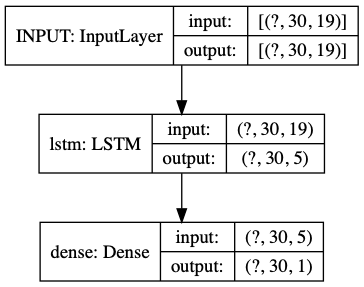

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [19]:
#Defining Model compiling parameters
learning_rate = parameter_list['learning_rate']
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, amsgrad=True)

#Loss and metric
loss_func = tf.keras.losses.MeanSquaredError(name='Loss: MSE')
metric_train = tf.keras.metrics.RootMeanSquaredError(name='T_RMSE')
metric_val = tf.keras.metrics.RootMeanSquaredError(name='V_RMSE')

#Creating summary writer
summary_writer = tf.summary.create_file_writer(logdir= parameter_list['log_dir'])

#Creating checkpoint instance
checkpoint = tf.train.Checkpoint(epoch = tf.Variable(0), optimizer = optimizer, model = model)
save_directory = parameter_list['checkpoint_dir']
manager = tf.train.CheckpointManager(checkpoint, directory= save_directory, 
                                    max_to_keep= parameter_list['max_checkpoint_keep'])
checkpoint.restore(manager.latest_checkpoint)

#Checking if previous checkpoint exists
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")
    
#Initialing training variables
global_step = 0
global_step_val = 0
val_min = 0

Initializing from scratch.


In [20]:
#Starting training
with summary_writer.as_default():

    epochs = parameter_list['epochs']

    for epoch in range(epochs):

        start_time = time.time()

        print('\nStart of epoch %d' %(epoch+1))

        # Iterate over the batches of the dataset.
        for step, (local_forecast, analysis) in enumerate(train_dataset):

            global_step += 1

            # Open a GradientTape to record the operations run
            # during the forward pass, which enables autodifferentiation.
            with tf.GradientTape() as tape:

                pred_analysis = model(local_forecast)

                #Calculating relative loss
                loss = loss_func(analysis, pred_analysis)

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))

            metric_train(analysis, pred_analysis)

            # Log of validation results  
            if (step % parameter_list['log_freq']) == 0:
                print('Training loss (for one batch) at step %s: %s' % (step+1, float(loss)))
                print('Seen so far: %s samples' % ((global_step) * parameter_list['batch_size']))
                
        # Display metrics at the end of each epoch.
        train_acc = metric_train.result()
        print('Training acc over epoch: %s \n' % (float(train_acc)))

        if not(epoch % parameter_list['summery_freq']):
            tf.summary.scalar('Loss_total', loss, step= epoch)
            tf.summary.scalar('Train_RMSE', train_acc, step= epoch)

        # Reset training metrics at the end of each epoch
        metric_train.reset_states()

        #Code for validation at the end of each epoch
        for step_val, (local_forecast_val, analysis_val) in enumerate(val_dataset):

            global_step_val += 1

            pred_analysis_val = model(local_forecast_val)

            val_loss = loss_func(analysis_val, pred_analysis_val)
            metric_val(analysis_val, pred_analysis_val)

            if (step_val % parameter_list['log_freq']) == 0:
                print('Validation loss (for one batch) at step %s: %s' % (step_val, float(val_loss)))
                print('Seen so far: %s samples' % ((step + 1) * parameter_list['batch_size']))
                
        val_acc = metric_val.result()
        print('Validation acc over epoch: %s \n' % (float(val_acc)))
        
        if not(epoch % parameter_list['summery_freq']):
            tf.summary.scalar('Loss_total_val', val_loss, step= epoch)
            tf.summary.scalar('Val_RMSE', metric_val.result(), step= epoch)
            
        # Reset training metrics at the end of each epoch
        metric_val.reset_states()

        checkpoint.epoch.assign_add(1)
        if int(checkpoint.epoch + 1) % parameter_list['num_epochs_checkpoint'] == 0:
            save_path = manager.save()
            print("Saved checkpoint for epoch {}: {}".format(int(checkpoint.epoch), save_path))
            print("loss {:1.2f}".format(loss.numpy()))

        if math.isnan(val_acc):
            print('Breaking out as the validation loss is nan')
            break                

        if (epoch > 19):
            if not (epoch % parameter_list['early_stop_patience']):
                if not (val_min):
                    val_min = val_acc
                else:
                    if val_min > val_acc:
                        val_min = val_acc
                    else:
                        print('Breaking loop as validation accuracy not improving')
                        save_path = manager.save()
                        print("Saved checkpoint for epoch {}: {}".format(int(checkpoint.epoch), save_path))
                        print("loss {:1.2f}".format(loss.numpy()))
                        break

        print('Time for epoch (in minutes): %s' %((time.time() - start_time)/60))


Start of epoch 1
Training loss (for one batch) at step 1: 40.053932189941406
Seen so far: 250 samples
Training loss (for one batch) at step 6: 42.66447067260742
Seen so far: 1500 samples
Training loss (for one batch) at step 11: 41.161865234375
Seen so far: 2750 samples
Training loss (for one batch) at step 16: 44.37649917602539
Seen so far: 4000 samples
Training loss (for one batch) at step 21: 41.0267219543457
Seen so far: 5250 samples
Training loss (for one batch) at step 26: 40.32449722290039
Seen so far: 6500 samples
Training loss (for one batch) at step 31: 43.94984436035156
Seen so far: 7750 samples
Training loss (for one batch) at step 36: 40.507755279541016
Seen so far: 9000 samples
Training acc over epoch: 6.42230749130249 

Validation loss (for one batch) at step 0: 41.06425476074219
Seen so far: 9250 samples
Validation acc over epoch: 6.380187511444092 

Saved checkpoint for epoch 1: ./checkpoint/ckpt-1
loss 42.65
Time for epoch (in minutes): 0.08243705034255981

Start of 

In [21]:
model.save('model.h5')

In [22]:
global_step

185

In [ ]:
#Defining Model compiling parameters
optimizer = tf.keras.optimizers.Adam